In [44]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
import pickle
import os


from training import *
from models import *
from A2C_agent import *
from helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data and agents

In [45]:

# # Load all_* dictionaries
# with open('agent1_data/all_dicts.pkl', 'rb') as f:
#     all_critic_losses, all_actor_losses, all_episode_rewards, \
#         all_evaluation_reward_means, all_evaluation_reward_stds, all_evaluation_value_trajectories = pickle.load(f)

# # Load agent1 dictionary
# with open('agent1_data/agent1.pkl', 'rb') as f:
#     agent1 = pickle.load(f)

# 3.4 Agent 3: n-step returns


In [50]:
device = "cpu"
print(device)

# hyperparameters
k=1
n=6
gamma_ = 0.99
lr_actor = 1e-5
lr_critic = 1e-3
total_steps_budget = 500000

# neural network structure
input_size = 4
hidden_size = 64
output_size_actor = 2
output_size_critic = 1

seeds = [77, 777, 7777]

agent3 = {}
all_critic_losses = {}
all_actor_losses = {}
all_episode_rewards = {}
all_evaluation_reward_means = {}
all_evaluation_reward_stds = {}
all_evaluation_value_trajectories = {}


cpu


In [47]:
for i in range(3):
    
    set_seed(seeds[i])
    # Initialize environment, agent and optimizers
    env = gym.make('CartPole-v1')
    agent = Agent(k, n, input_size, hidden_size, \
                    output_size_actor, output_size_critic, \
                    gamma_, lr_actor, lr_critic, \
                    device=device)
    actor_optimizer = torch.optim.Adam(agent.actor.parameters(), lr_actor)
    critic_optimizer = torch.optim.Adam(agent.critic.parameters(), lr_critic)

    # Initialize recording lists and assign them to dictionary key
    all_critic_losses[i] = []
    all_actor_losses[i] = []
    all_episode_rewards[i] = []
    all_evaluation_reward_means[i] = []
    all_evaluation_reward_stds[i] = []
    all_evaluation_value_trajectories[i] = []

    critic_losses = []
    actor_losses = []
    episode_rewards = []

    batch = []

    # reset flags
    reached_train_budget = False
    episode = 0
    done = False

    # Training loop
    while not reached_train_budget:
        reset_seed = np.random.randint(0, 1000000) # Random seed for resetting the environment, fixed sequence because of set_seed() call above
        state, _ = env.reset(seed=reset_seed)
        state = tensor(state).to(device)  # Convert state to a tensor
        episode_reward = 0

        # Run an episode
        while not done:
            action = agent.select_action(state, mode="learning")
            next_state, reward, terminated, truncated, _ = env.step(action.detach().item())
            agent.num_steps += 1
            next_state = tensor(next_state).to(device)  # Convert next_state to a tensor
            done = terminated or truncated
            episode_reward += reward

            # Add the experience to the batch
            experience = (state, action, reward, next_state, terminated)
            batch.append(experience)

            # Train the agent when batch is full
            if len(batch) >= agent.n or done:
                actor_loss, critic_loss = train_batch(agent, actor_optimizer, critic_optimizer, batch)
                critic_losses.append(critic_loss)
                actor_losses.append(actor_loss)
                batch = []
            state = next_state

            # logging procedures
            if agent.num_steps % 20000 == 0: 
                print(f"---- Proceeding to evaluate model {i} ... ----")
                mean_reward, std_reward, value_trajectories = agent.evaluate_agent(num_episodes=10)
                all_evaluation_reward_means[i].append(mean_reward)
                all_evaluation_reward_stds[i].append(std_reward)
                all_evaluation_value_trajectories[i].append(value_trajectories[0])
                print(f"Mean reward: {mean_reward:.2f}, Std reward: {std_reward:.2f}, total steps: {agent.num_steps}")
                print("----     Evaluation finished        ----")
            
            if agent.num_steps % 1000 == 0:
                all_episode_rewards[i].append(episode_rewards[-1])
                all_actor_losses[i].append(actor_losses[-1])
                all_critic_losses[i].append(critic_losses[-1])


            if (agent.num_steps >= total_steps_budget): 
                reached_train_budget = True
                break

        done = False
        episode += 1
        episode_rewards.append(episode_reward)
        if episode % 100 == 0:
            print(f"-------- Episode {episode} ended with reward {episode_reward} for model {i} --------")
            print(f"Actor loss: {actor_losses[-1]:.4f}, Critic loss: {critic_losses[-1]:.4f}")
            print(f"Total steps taken during training: {agent.num_steps}")

    if reached_train_budget:
        print(f"Reached total training budget of {total_steps_budget} steps ----> Stopping training at episode {episode}")
    
    agent3[i] = agent # record the agent

env.close()


-------- Episode 100 ended with reward 29.0 for model 0 --------
Actor loss: 0.7774, Critic loss: 1.6058
Total steps taken during training: 2408
-------- Episode 200 ended with reward 10.0 for model 0 --------
Actor loss: 0.9474, Critic loss: 1.4357
Total steps taken during training: 5002
-------- Episode 300 ended with reward 16.0 for model 0 --------
Actor loss: 0.8084, Critic loss: 1.9073
Total steps taken during training: 7456
-------- Episode 400 ended with reward 45.0 for model 0 --------
Actor loss: 0.6751, Critic loss: 0.7428
Total steps taken during training: 9941
-------- Episode 500 ended with reward 20.0 for model 0 --------
Actor loss: -0.9833, Critic loss: 2.1898
Total steps taken during training: 12452
-------- Episode 600 ended with reward 40.0 for model 0 --------
Actor loss: 0.5480, Critic loss: 1.1609
Total steps taken during training: 15333
-------- Episode 700 ended with reward 13.0 for model 0 --------
Actor loss: -0.7862, Critic loss: 2.8297
Total steps taken dur

### training logging info

- losses and rewards are every 1k step
- evaluation rewards and value_trajectories are every 20k steps

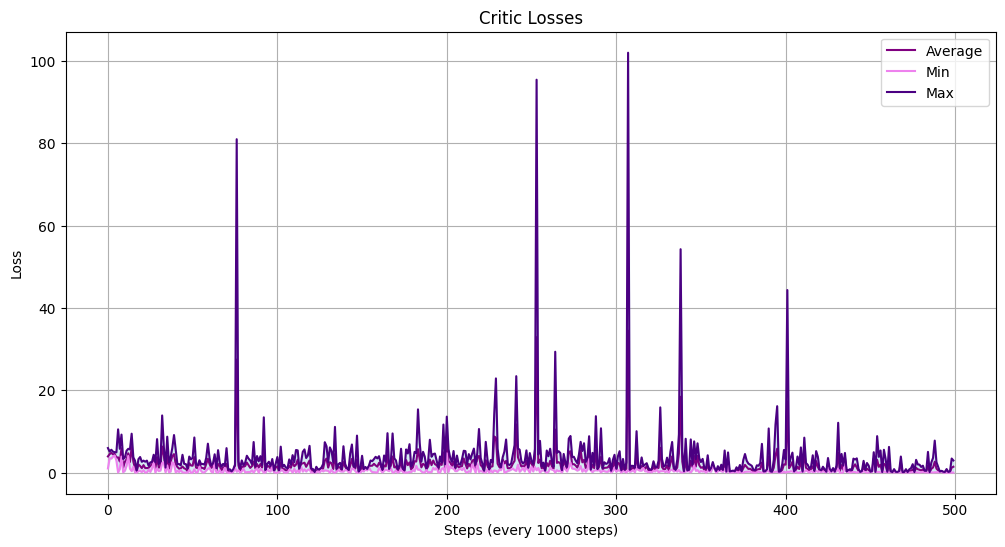

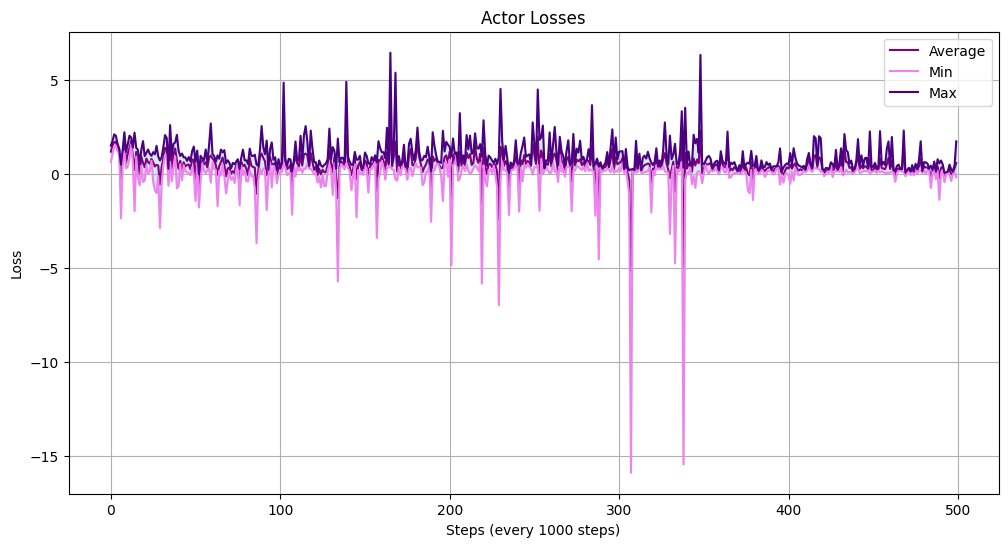

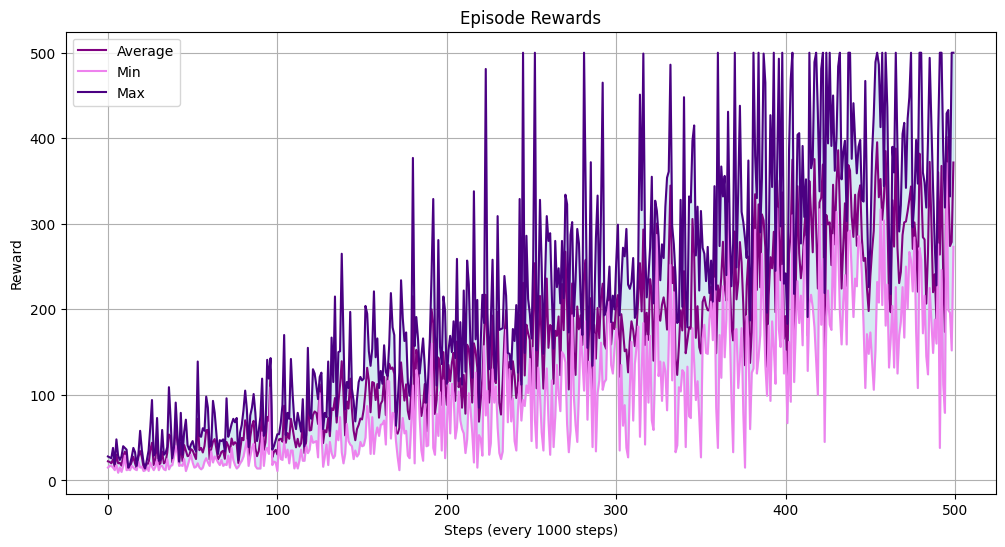

In [39]:
# Get stats for all_critic_losses
min_critic_losses, max_critic_losses, avg_critic_losses = get_stats(all_critic_losses)
min_actor_losses, max_actor_losses, avg_actor_losses = get_stats(all_actor_losses)
min_episode_rewards, max_episode_rewards, avg_episode_rewards = get_stats(all_episode_rewards)

# Plot stats for all_critic_losses
plot_stats(min_critic_losses, max_critic_losses, avg_critic_losses, title='Critic Losses',ylabel='Loss',xlabel='Steps (every 1000 steps)')
plot_stats(min_actor_losses, max_actor_losses, avg_actor_losses, title='Actor Losses',ylabel='Loss',xlabel='Steps (every 1000 steps)')
plot_stats(min_episode_rewards, max_episode_rewards, avg_episode_rewards, title='Episode Rewards',ylabel='Reward',xlabel='Steps (every 1000 steps)')

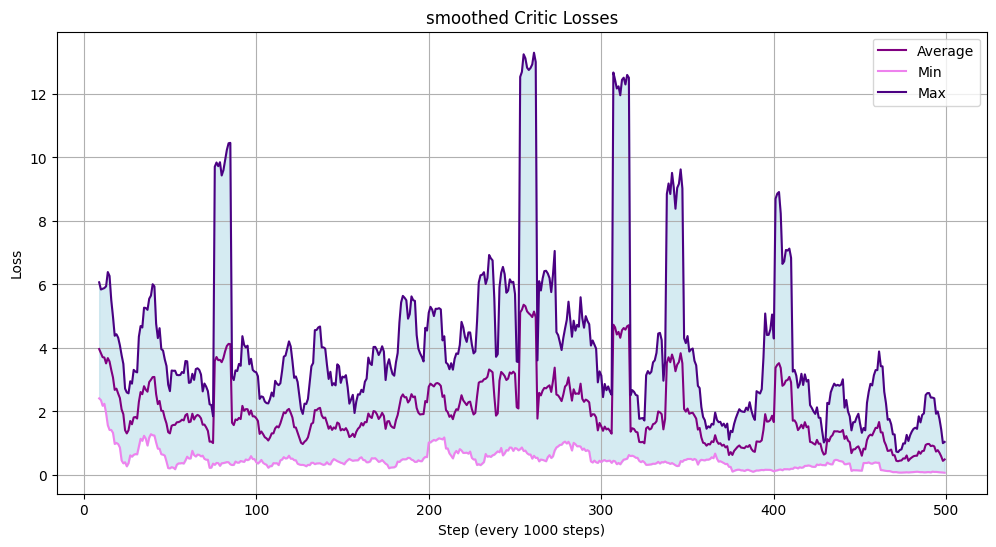

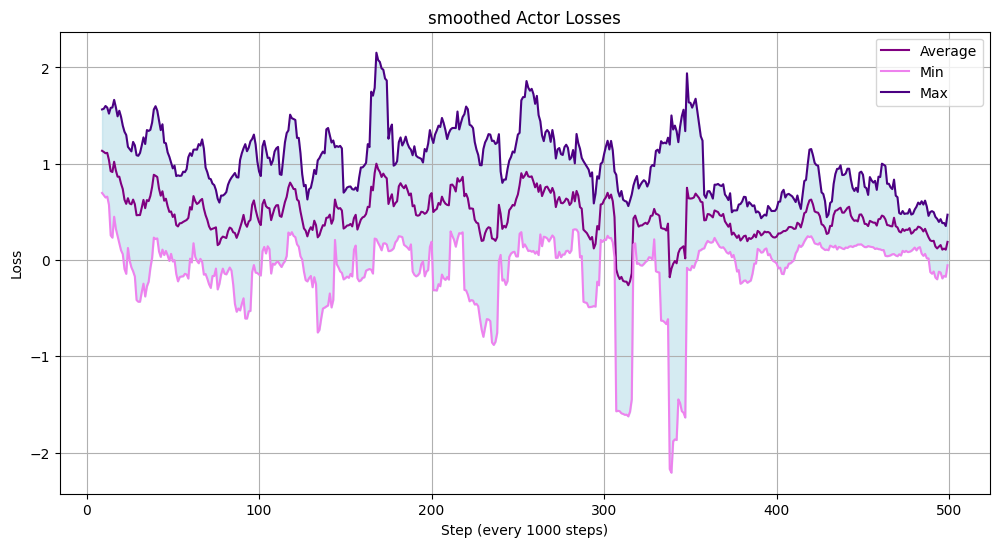

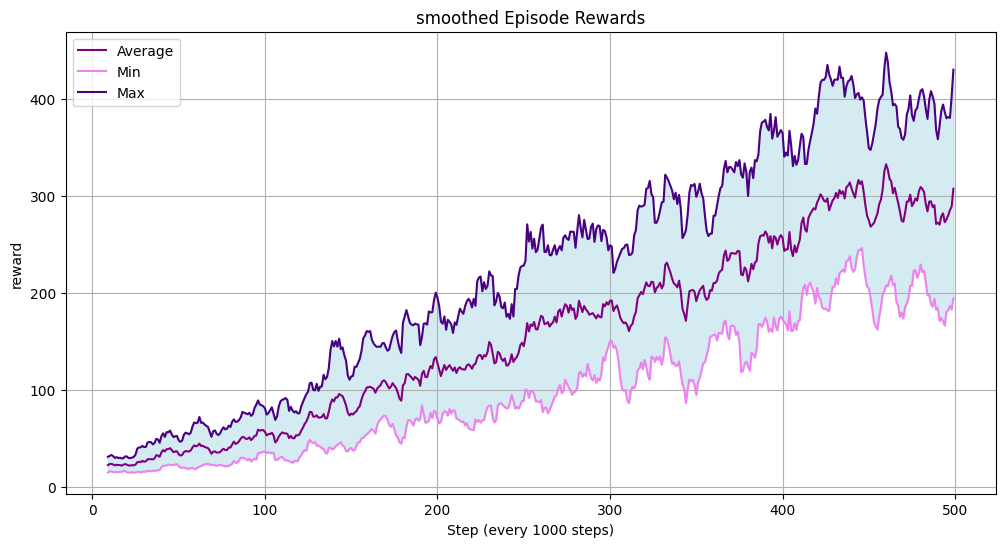

In [40]:
# Plot smoothed stats for all_critic_losses
plot_smoothed_stats(min_critic_losses, max_critic_losses, avg_critic_losses, window_size=10, title='smoothed Critic Losses', ylabel='Loss', xlabel='Step (every 1000 steps)')
plot_smoothed_stats(min_actor_losses, max_actor_losses, avg_actor_losses, window_size=10, title='smoothed Actor Losses', ylabel='Loss', xlabel='Step (every 1000 steps)')
plot_smoothed_stats(min_episode_rewards, max_episode_rewards, avg_episode_rewards, window_size=10, title='smoothed Episode Rewards', ylabel='reward', xlabel='Step (every 1000 steps)')

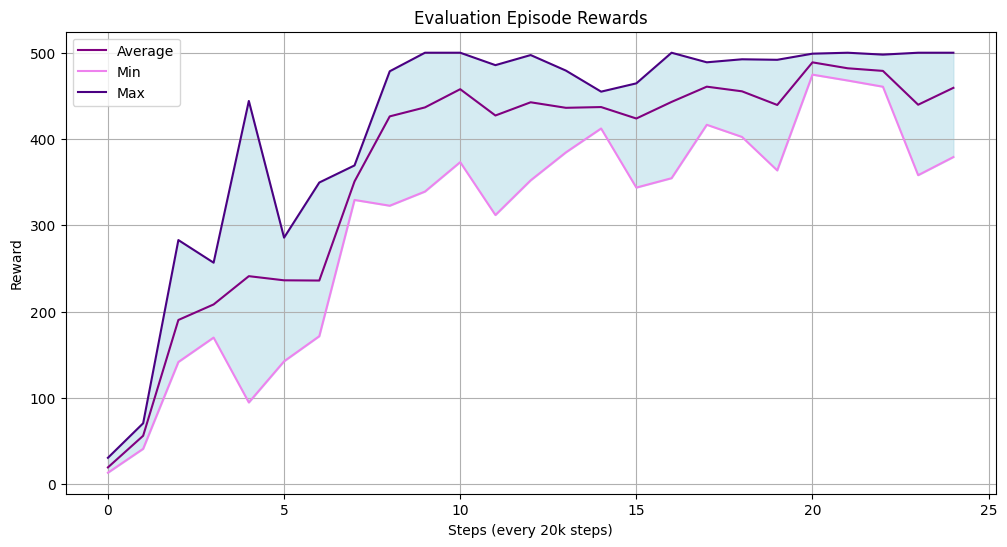

In [41]:
# Get stats for evaluation rewards
min_eval_rew, max_eval_rew, avg_eval_rew = get_stats(all_evaluation_reward_means)


# Plot stats for all_critic_losses

plot_stats(min_eval_rew, max_eval_rew, avg_eval_rew, title='Evaluation Episode Rewards',ylabel='Reward',xlabel='Steps (every 20k steps)')


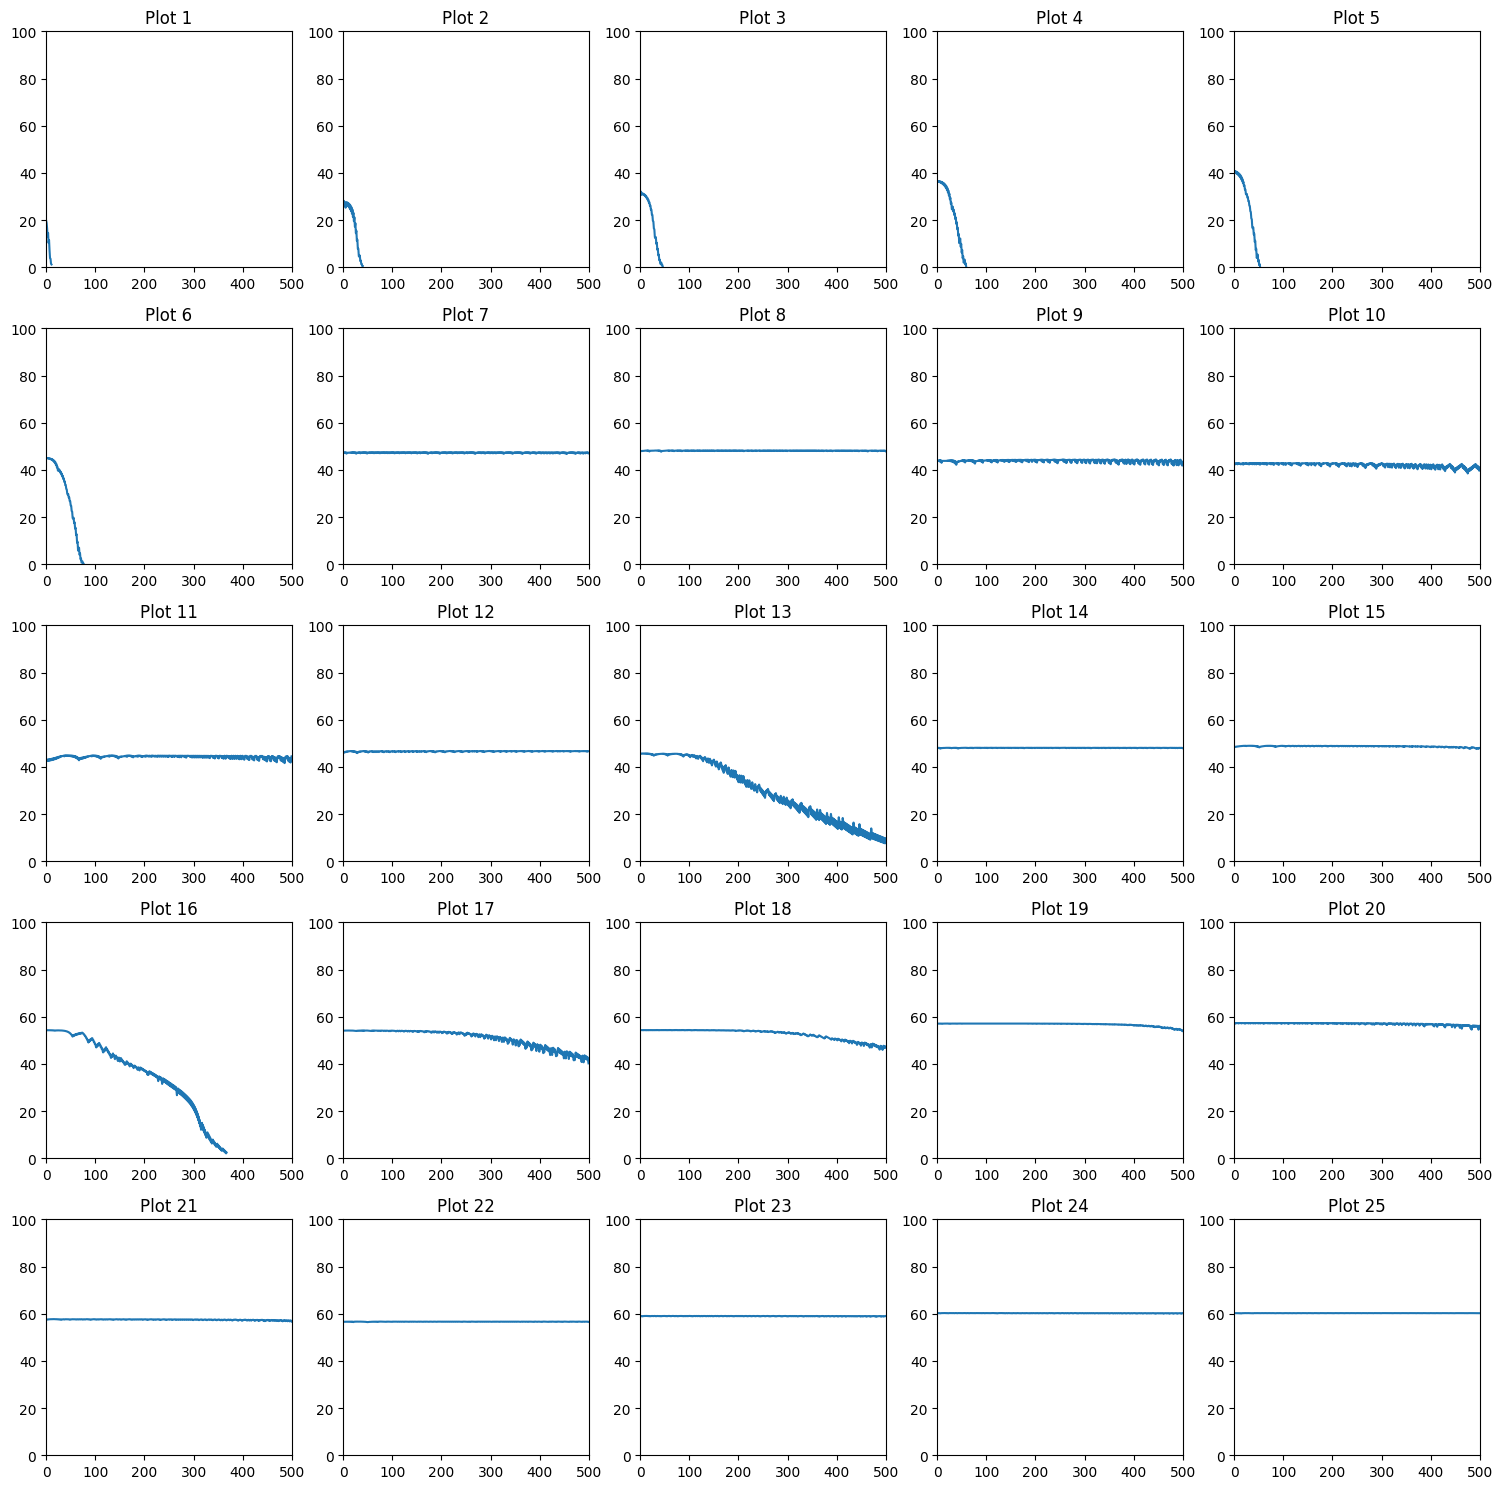

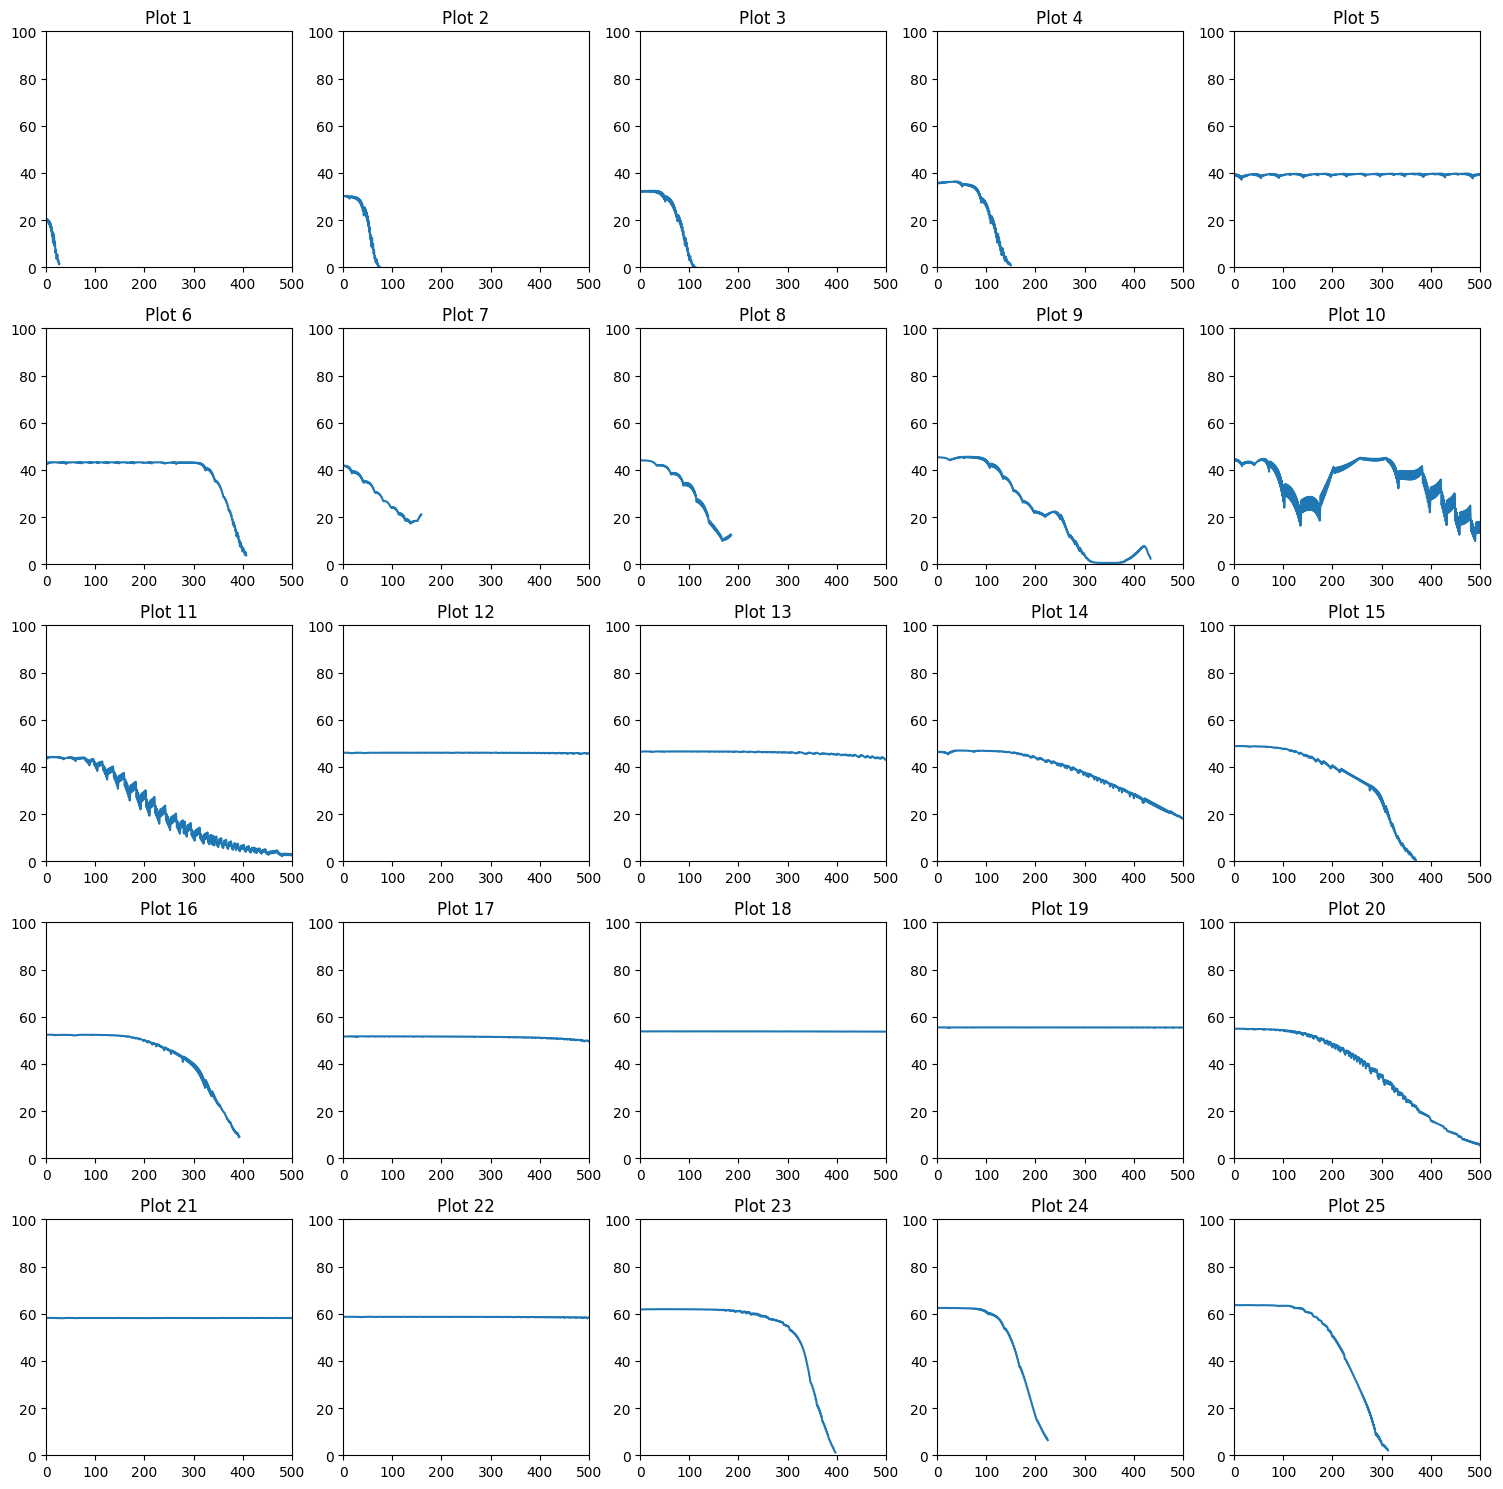

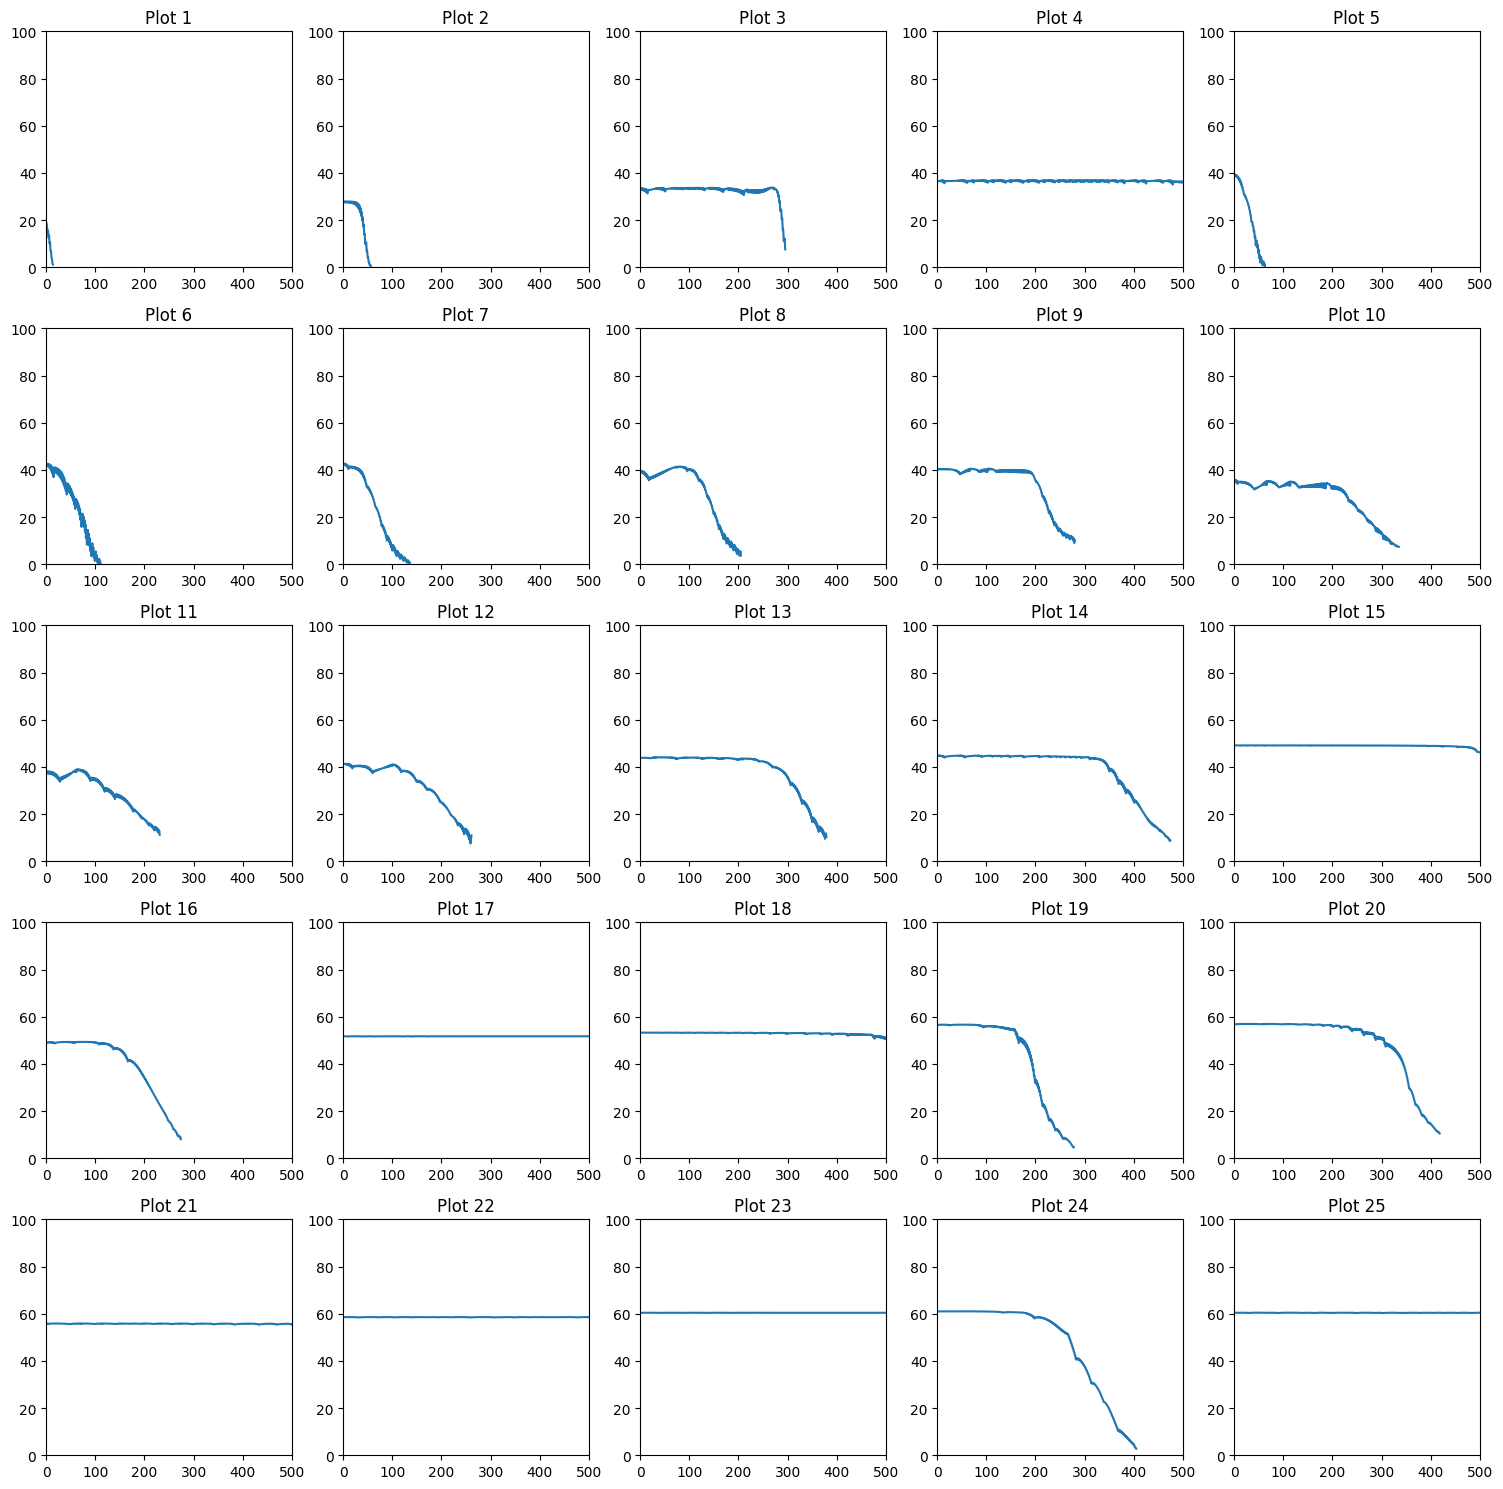

In [42]:
for k in range(3):
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))  # Create a 5x5 grid of subplots

    for i in range(5):
        for j in range(5):
            axs[i, j].plot(torch.stack(all_evaluation_value_trajectories[k][5*i+j]).detach().numpy())
            axs[i, j].set_title(f'Plot {5*i+j+1}')  # Optional: give each plot a unique title
            axs[i, j].set_ylim([0, 100])  # Set y-axis limits
            axs[i, j].set_xlim([0, 500])  # Set y-axis limits

    plt.tight_layout()  # Optional: improve layout
    plt.show()

### saving agents and data

In [43]:
# # Save all_* dictionaries
folder_name = "agent3_data"
os.makedirs(folder_name, exist_ok=True)

with open(folder_name+'/all_dicts.pkl', 'wb') as f:
    pickle.dump([all_critic_losses, all_actor_losses, all_episode_rewards, \
                 all_evaluation_reward_means, all_evaluation_reward_stds, all_evaluation_value_trajectories], f)

# Save agent3 dictionary
with open(folder_name+'/agent3.pkl', 'wb') as f:
    pickle.dump(agent3, f)